# Covid-19 data forecasting: ARIMA

## Table of content
1. [Data preprocessing](#Data-preprocessing)
2. [Data classification](#Data-classification)
* [K-Nearest Neighbours](#K-Nearest-Neighbours)
<br>-- Results --
* [Poland](#Poland)<br>
[Autocorrelation](#Autocorrelation)<br>
[Model summary](#Model-summary)<br>
[Residuals](#Residuals)<br>
[Predictions](#Predictions)<br>
[-Ex post verification](#Ex-post-verification)<br>
[-Forecast for the next 20 days](#Forecast-for-the-next-20-days)
* [Switzerland](#Switzerland)
* [Belarus](#Belarus)
* [Any other country](#Any-other-country)

In [1]:
import numpy as np
import pandas as pd
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

## Data preprocessing

In [2]:
url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-05-14.xlsx'
df = pd.read_excel(url)
#df['dateRep'] = pd.to_datetime(df['dateRep']).dt.date
df.head(3)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,2020-05-14,14,5,2020,259,3,Afghanistan,AF,AFG,37172386.0,Asia
1,2020-05-13,13,5,2020,280,5,Afghanistan,AF,AFG,37172386.0,Asia
2,2020-05-12,12,5,2020,285,2,Afghanistan,AF,AFG,37172386.0,Asia


In [3]:
df=df.sort_values(by=['countriesAndTerritories', 'dateRep'])
df['cum_cases'] = df.groupby(['countriesAndTerritories'])['cases'].apply(lambda x: x.cumsum())
df['cum_deaths'] = df.groupby(['countriesAndTerritories'])['deaths'].apply(lambda x: x.cumsum())
lista=df[df.cum_cases>df['cum_cases'].max()/20]['countriesAndTerritories'].unique()
lista=np.append(lista,['Poland'])
df[df.countriesAndTerritories.isin(lista)].groupby(['countriesAndTerritories'])[['cases','deaths']].describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

cases                                            \
                          count          mean           std    min    10%   
countriesAndTerritories                                                     
Brazil                    136.0   1389.514706   2622.150508    0.0    0.0   
Canada                    136.0    531.455882    705.936026    0.0    0.0   
China                     136.0    617.823529   1585.323936    0.0    0.0   
France                    136.0   1034.808824   1538.769256    0.0    0.0   
Germany                   136.0   1266.463235   1831.618543    0.0    0.0   
India                     135.0    577.800000   1041.404088    0.0    0.0   
Iran                      136.0    828.860294    959.150876    0.0    0.0   
Italy                     136.0   1633.117647   1918.915110    0.0    0.0   
Peru                       68.0   1122.147059   1296.339476    0.0    6.0   
Poland                     70.0    245.771429    150.849303    1.0   17.1   
Russia                    136.0   1781.404412   3337.727667    0.0    0.0   
Spain                     135.0   1694.007407   2475.098022 -713.0    0.0   
Turkey                     62.0   2308.290323   1496.575680    1.0  178.9   
United_Kingdom            136.0   1689.007353   2236.722948    0.0    0.0   
United_States_of_America  136.0  10226.073529  13255.681130    0.0    0.0   

                                                                      deaths  \
                              25%     50%       75%      90%      max  count   
countriesAndTerritories                                                        
Brazil                       0.00     3.0   1496.75   5449.5  11385.0  136.0   
Canada                       0.00     6.0   1255.25   1581.0   2760.0  136.0   
China                       14.75    66.0    398.00   2073.5  15141.0  136.0   
France                       0.00   164.0   1614.00   3823.5   7578.0  136.0   
Germany                      0.00   102.0   2120.75   4285.5   6294.0  136.0   
India                        0.00     2.0    784.50   1991.8   4213.0  135.0   
Iran                         0.00   669.0   1367.25   1984.5   5275.0  136.0   
Italy                        0.00   773.5   3041.00   4681.0   6557.0  136.0   
Peru                        35.00   656.0   1766.75   3342.9   4247.0   68.0   
Poland                     112.00   276.5    344.75    422.3    595.0   70.0   
Russia                       0.00     0.0   1511.00   6755.0  11656.0  136.0   
Spain                        0.00   183.0   2933.50   5563.0   9181.0  135.0   
Turkey                    1543.00  2168.0   3144.75   4345.8   5138.0   62.0   
United_Kingdom               0.00    45.5   3987.75   5054.0   8719.0  136.0   
United_States_of_America     0.00   100.0  24129.00  30032.5  48529.0  136.0   

                                                                        \
                                mean         std  min  10%   25%   50%   
countriesAndTerritories                                                  
Brazil                     96.683824  188.201142  0.0  0.0   0.0   0.0   
Canada                     39.000000   63.391669  0.0  0.0   0.0   0.0   
China                      34.095588  116.240229  0.0  0.0   0.0   4.0   
France                    199.073529  338.291297  0.0  0.0   0.0   2.5   
Germany                    56.786765   86.413254  0.0  0.0   0.0   0.0   
India                      18.881481   35.383412  0.0  0.0   0.0   0.0   
Iran                       49.875000   57.118128  0.0  0.0   0.0  16.0   
Italy                     228.720588  275.423356  0.0  0.0   0.0  45.0   
Peru                       31.897059   35.511671  0.0  0.0   1.0  14.5   
Poland                     12.300000   10.749250  0.0  0.0   1.0  13.0   
Russia                     16.264706   30.737415  0.0  0.0   0.0   0.0   
Spain                     200.770370  284.132457  0.0  0.0   0.0   0.0   
Turkey                     63.741935   41.194037  0.0  3.2  18.5  66.5   
United_Kingdom

## Arima model functions

In [4]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def data_preprocess(country):
    country=country.replace(" ","_")
    ts=df[df.countriesAndTerritories==country][['dateRep','cases']]
    #ts=ts.sort_values(by='dateRep')
    ts.set_index('dateRep', inplace=True)
    return ts

def autocorr(ts):
    register_matplotlib_converters()
    fig, axes = plt.subplots(3, 2, sharex=False,figsize=(20,10))
    for i in range(3):
        axes[i, 0].tick_params(axis='x',labelsize=8, rotation=20)
        axes[i, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        axes[i, 0].xaxis.set_major_locator(plt.MaxNLocator(8))
    axes[0, 0].plot(ts.cases)
    axes[0, 0].set_title('Original Series')
    fig.subplots_adjust( hspace=.5)
    plot_acf(ts.cases, ax=axes[0, 1])
    # 1st Difference
    axes[1, 0].plot(ts.cases.diff())
    axes[1, 0].set_title('1st Order Differencing')
    axes[1, 0].tick_params(axis='x',labelsize=8) #, rotation=20)
    plot_acf(ts.cases.diff().dropna(), ax=axes[1, 1])
    # 2nd  Difference
    axes[2, 0].plot(ts.cases.diff().diff())
    axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(ts.cases.diff().diff().dropna(), ax=axes[2, 1])
    plt.show()


def arima_model(ts, order=(1,2,1)):
    ts.dropna()
    global temp
    try:
        temp=ts.index
        ts.index = pd.DatetimeIndex(ts.index).to_period('D')
    except:
        pass
    l={}
    for p in range(3):
        for d in range(3):
            for q in range(3):
                try:
                    arima_mod=ARIMA(ts,(p,d,q)).fit(transparams=True)
                    x=arima_mod.aic
                    x1= p,d,q
                    l[x]=x1
                    if x==min(l.keys()):
                        a,b,c=p,d,q
                    aic.append(x)
                    pdq.append(x1)
                except:
                    pass
    model = ARIMA(ts.cases, order=(a,b,c)).fit(disp=0)
    return model


def resid(model):
    residuals = pd.DataFrame(model.resid)
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

def arima_fcst(ts,model=None,days_forward=0):
    global country
    try:
        ts.index=temp
    except:
        pass
    if model==None:
        train = ts.cases[:round(len(ts.cases)*7/8)]
        test = ts.cases[round(len(ts.cases)*7/8):] 
        # forecast
        fcst, se, conf = arima_model(ts[:round(len(ts.cases)*7/8)]).forecast(round(len(ts.cases)*1/8), alpha=0.05)  # 95% confidence
        fcst_series = pd.Series(fcst, index=test.index)
        #confidence intervals
        lower = pd.Series(conf[:, 0], index=test.index)
        upper = pd.Series(conf[:, 1], index=test.index)
    else:
        test=ts.cases
        fcst, se, conf = model.forecast(days_forward, alpha=0.05)  # 95% confidence
        fcst_series = pd.Series(fcst, index=pd.date_range(start=ts.index.max()+ timedelta(days=1), end=ts.index.max()+ timedelta(days=days_forward), freq='D'))
        lower = pd.Series(conf[:, 0], index=pd.date_range(start=ts.index.max()+ timedelta(days=1), end=ts.index.max()+ timedelta(days=days_forward), freq='D'))
        upper = pd.Series(conf[:, 1], index=pd.date_range(start=ts.index.max()+ timedelta(days=1), end=ts.index.max()+ timedelta(days=days_forward), freq='D'))

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    if model==None:
        plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fcst_series, label='predicted')
    plt.axvline(ts.index.max(), alpha=0.5, c='red',linestyle='--')
    plt.text(ts.index.max(), ts.cases.max()/6,ts.index.max().date() ,rotation=90, fontsize=9, horizontalalignment='right')
    if model==None:
        plt.title('Forecast vs Actual: ex post model verification')
    else:
        plt.title('Predicted cases for the next %d days' %(days_forward))
    plt.fill_between(lower.index, lower, upper, color='k', alpha=0.15)
    plt.tick_params(axis='x',labelsize=8, rotation=0)
    plt.legend(loc='upper left', fontsize=8)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=round((ts.index.max()-ts.index.min()).days/7)))
    plt.show()

def get_arima(country):
    ts=data_preprocess(country)
    autocorr(ts)
    model=arima_model(ts)
    print(model.summary())
    resid(model)
    model.plot_predict(dynamic=False);plt.show()
    arima_fcst(ts)
    arima_fcst(ts,model, days_forward=20)


## Results

## Poland

### Autocorrelation

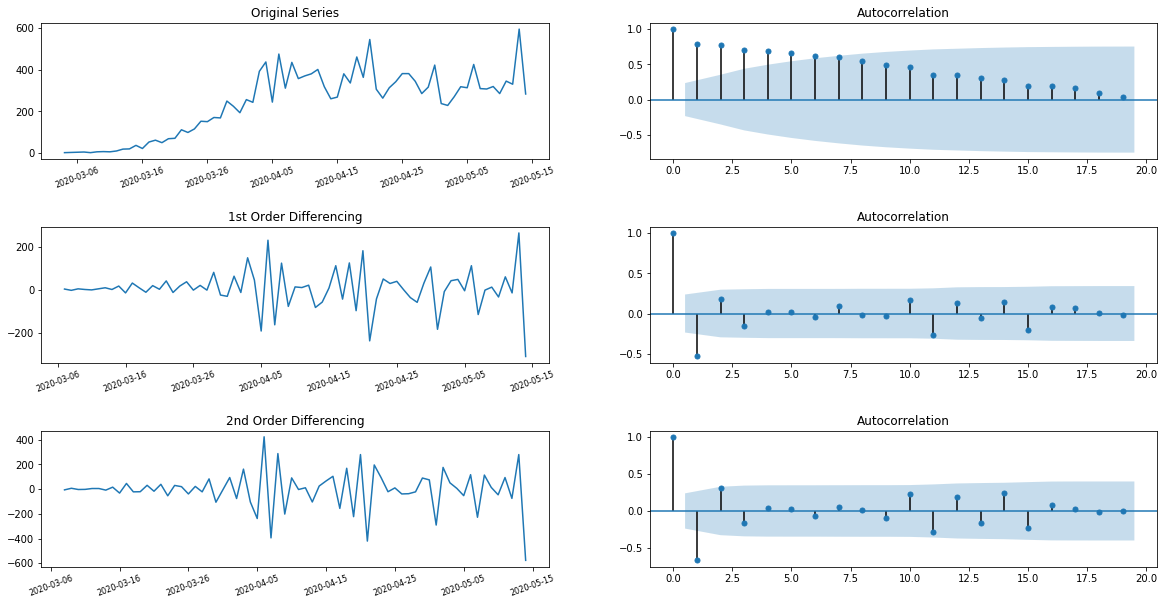

In [5]:
country='Poland'
ts=data_preprocess(country)
autocorr(ts)

### Model summary

In [11]:
model=arima_model(ts)
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.cases   No. Observations:                   68
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -391.191
Method:                       css-mle   S.D. of innovations             72.444
Date:                Tue, 19 May 2020   AIC                            792.383
Time:                        14:00:40   BIC                            803.480
Sample:                    03-08-2020   HQIC                           796.780
                         - 05-14-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1529      0.169     -0.904      0.369      -0.484       0.179
ar.L1.D2.cases    -0.2012      0.216     -0.933      0.354      -0.624       0.221
ma.L1.D2.cases    -1.5774      0.205

### Residuals

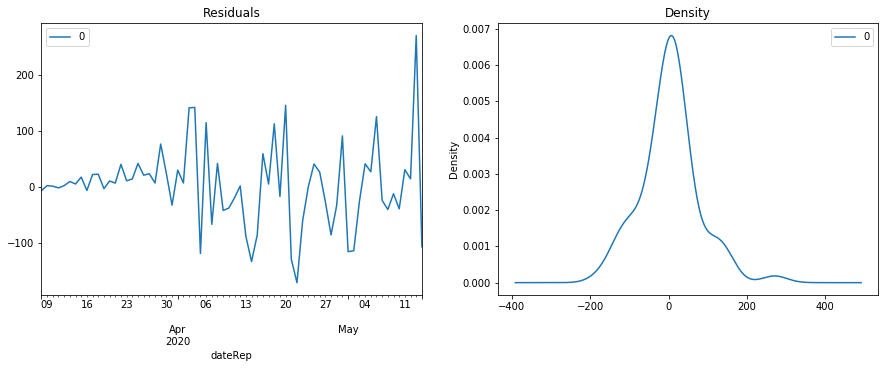

In [7]:
resid(model)

### Predictions

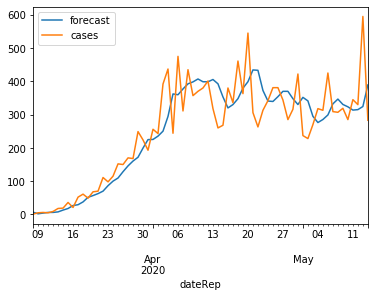

In [8]:
model.plot_predict(dynamic=False);plt.show()

### Ex post verification

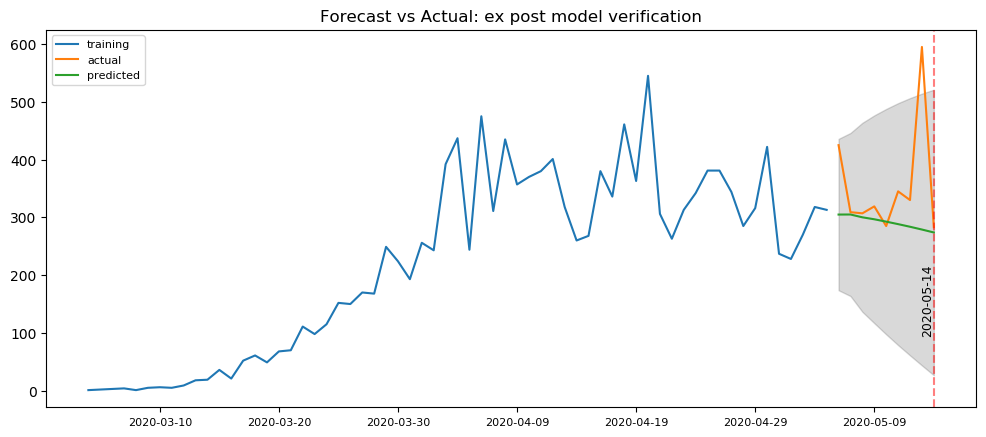

In [9]:
arima_fcst(ts)

### Forecast for the next 20 days

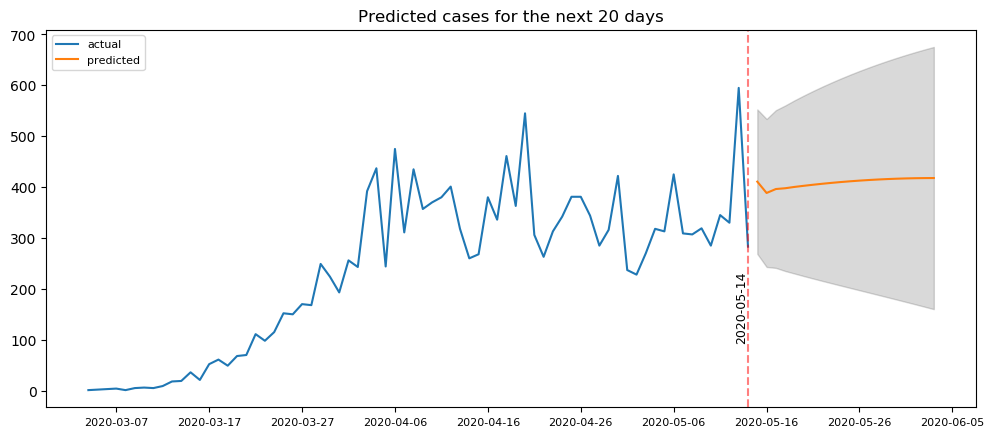

In [10]:
arima_fcst(ts,model, days_forward=20)

## Belarus

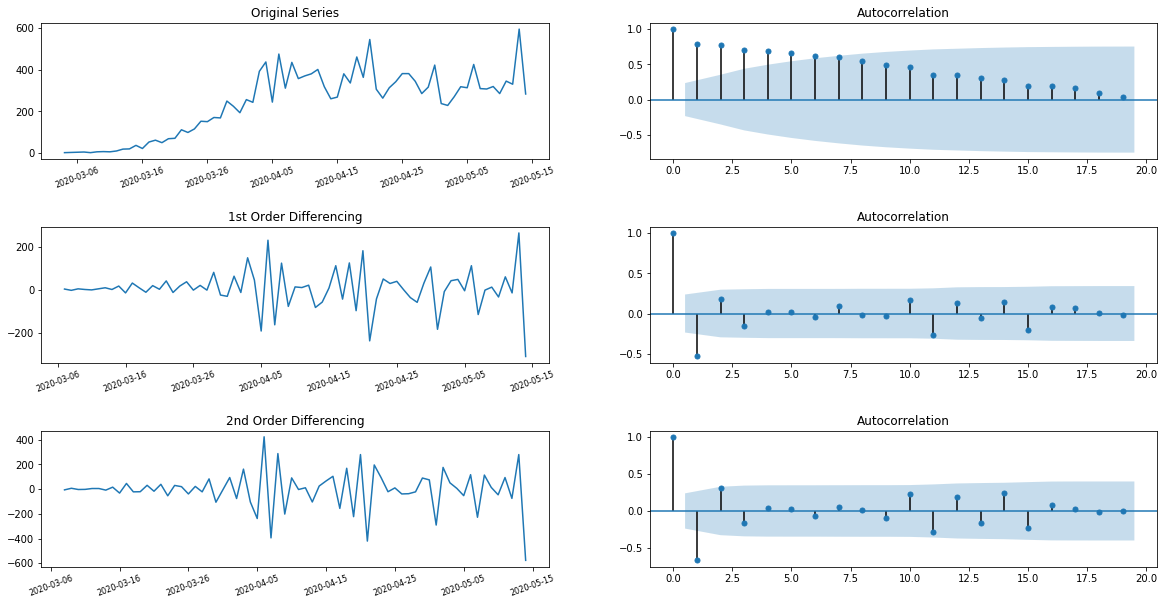

                             ARIMA Model Results                              
Dep. Variable:               D2.cases   No. Observations:                   68
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -391.191
Method:                       css-mle   S.D. of innovations             72.444
Date:                Tue, 19 May 2020   AIC                            792.383
Time:                        14:00:49   BIC                            803.480
Sample:                    03-08-2020   HQIC                           796.780
                         - 05-14-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1529      0.169     -0.904      0.369      -0.484       0.179
ar.L1.D2.cases    -0.2012      0.216     -0.933      0.354      -0.624       0.221
ma.L1.D2.cases    -1.5774      0.205

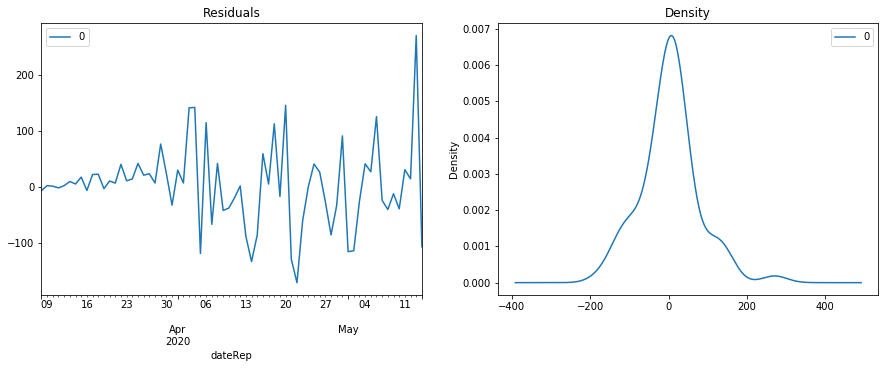

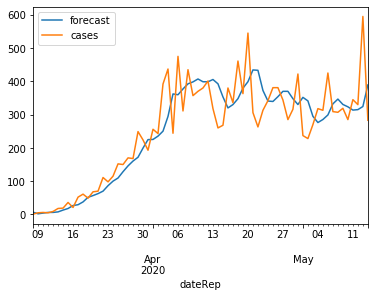

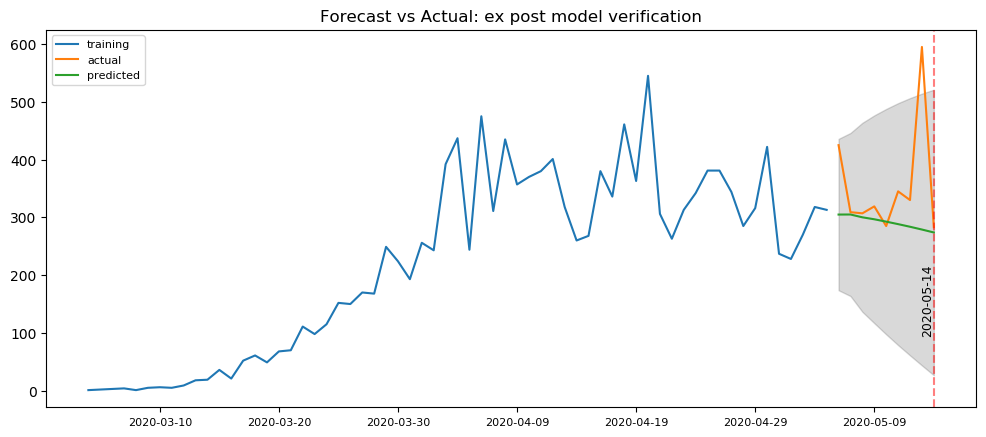

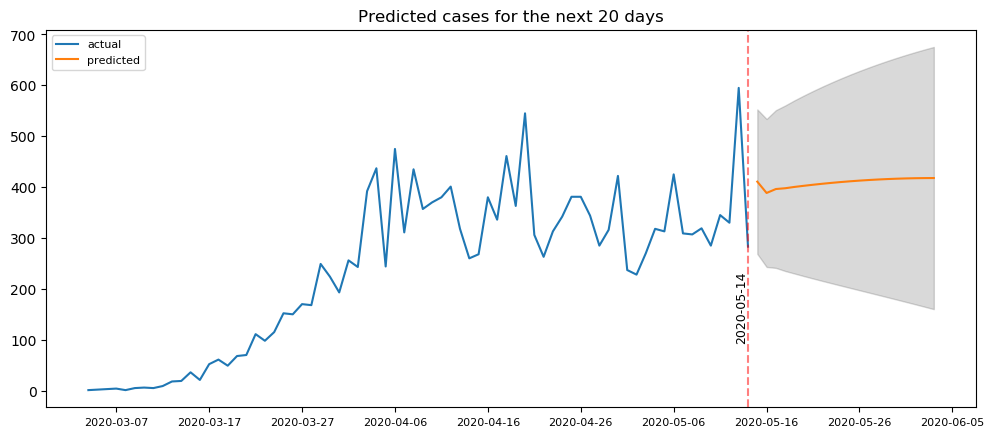

In [12]:
counry='Belarus'
get_arima(country)

## Switzerland

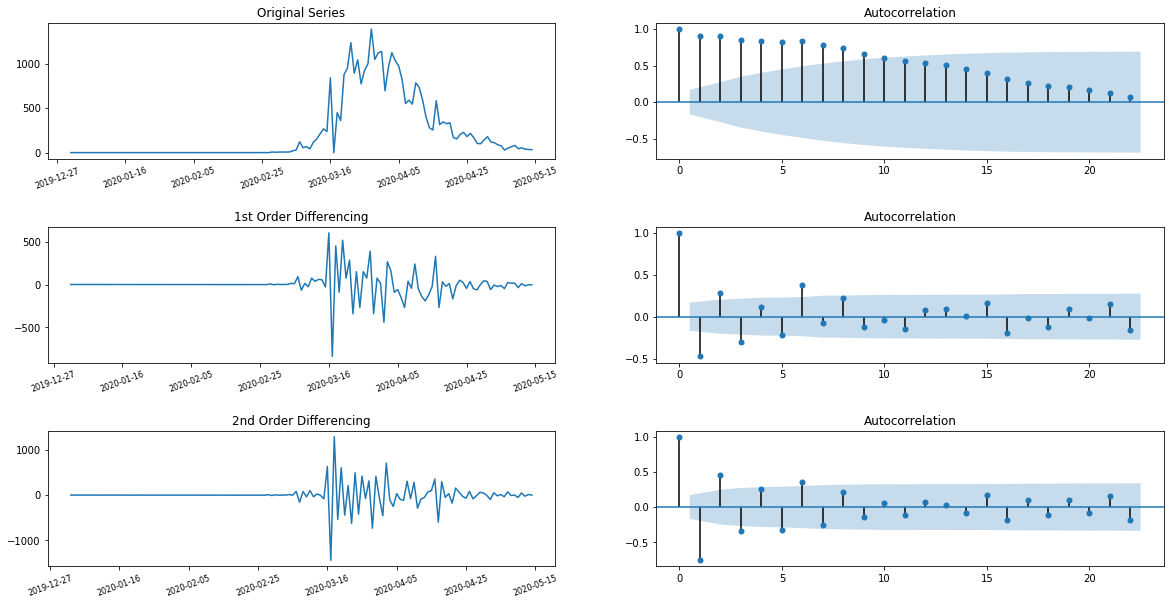

                             ARIMA Model Results                              
Dep. Variable:                D.cases   No. Observations:                  135
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -846.423
Method:                       css-mle   S.D. of innovations            127.682
Date:                Tue, 19 May 2020   AIC                           1702.846
Time:                        14:01:02   BIC                           1717.372
Sample:                    01-01-2020   HQIC                          1708.749
                         - 05-14-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2663      7.255      0.037      0.971     -13.954      14.486
ar.L1.D.cases    -0.8768      0.077    -11.353      0.000      -1.028      -0.725
ma.L1.D.cases     0.4376      0.120     

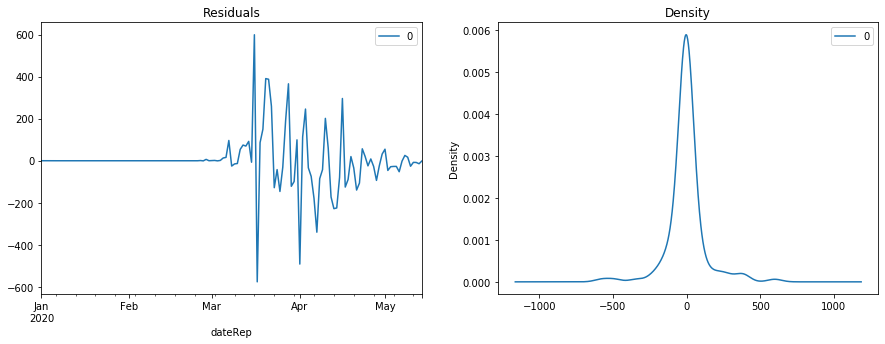

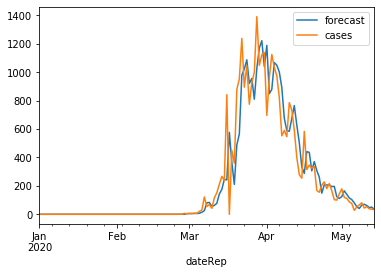

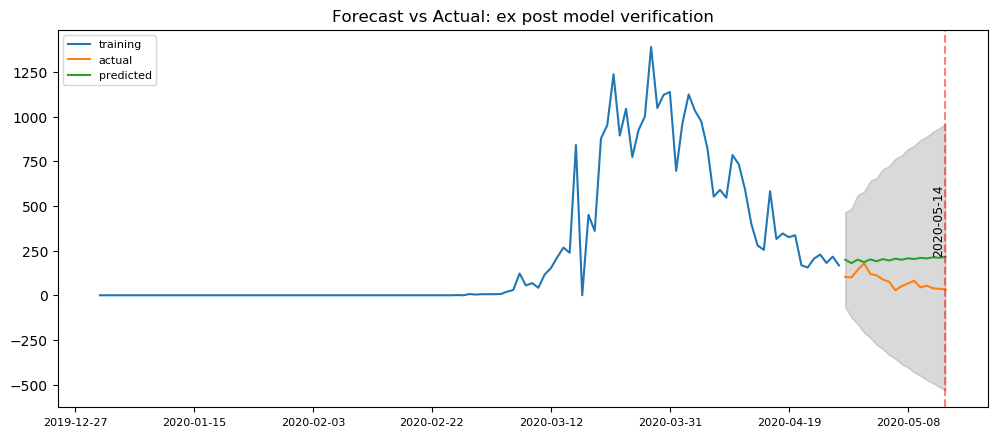

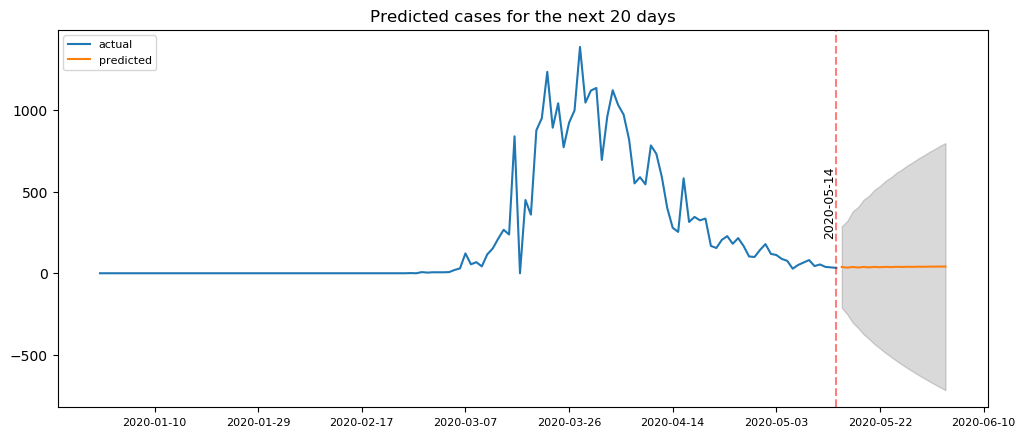

In [13]:
country='Switzerland'
get_arima(country)

## Any other country

In [ ]:
country=input()
get_arima(country)